Importación y Carga de Datos

In [104]:
# Importaciones correctas
import pandas as pd
import lightgbm as lgb
import catboost as cb
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split

df = pd.read_csv('telecom_customer_churn.csv')

Preprocesamiento

In [105]:

# 1. Preprocesamiento
# a. Eliminar entradas con el estado "Joined"
df = df[df['Customer Status'] != 'Joined']

# b. Crear la columna 'Churn' y asignar 1 si 'Customer Status' es 'Churned', de lo contrario 0
df['Churn'] = df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)

# c. Eliminar columnas con más del 50% de datos faltantes
threshold = int(0.5 * len(df))
df = df.dropna(thresh=threshold, axis=1)

# d. Reemplazar valores atípicos por la media
for col in df.select_dtypes(include=['float64', 'int64']):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[col] = df[col].apply(lambda x: df[col].mean() if (x < (Q1 - 1.5 * IQR)) or (x > (Q3 + 1.5 * IQR)) else x)

# e. Convertir variables categóricas a numéricas y llenar valores faltantes
for column in df.columns:
    if df[column].dtype == 'object' and column != 'Customer Status':
        # Llenar valores faltantes con la moda para columnas categóricas
        df[column].fillna(df[column].mode()[0], inplace=True)
        # Convertir variables categóricas a numéricas
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    elif df[column].dtype in ['int64', 'float64']:
        # Llenar valores faltantes con la mediana para columnas numéricas
        df[column].fillna(df[column].median(), inplace=True)

# Eliminar la columna 'Customer Status' antes de normalizar
df = df.drop(columns=['Customer Status'])

# f. Normalización
# Seleccionar solo las columnas que no son 'Churn' para la normalización
cols_to_scale = df.columns.difference(['Churn'])
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

Selección de características

In [106]:
# 2. Selección de características
xgb_for_feature_selection = XGBClassifier(
    objective='binary:logistic', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)
xgb_for_feature_selection.fit(df.drop('Churn', axis=1), df['Churn'])
threshold = 0.01  
selected_features = df.drop('Churn', axis=1).columns[(xgb_for_feature_selection.feature_importances_ > threshold)].tolist()
print("Características seleccionadas:", selected_features)

Características seleccionadas: ['Age', 'Married', 'Number of Dependents', 'Zip Code', 'Latitude', 'Number of Referrals', 'Tenure in Months', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Premium Tech Support', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charge', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges']


Balanceo con SMOTE

In [107]:
# 3. Balanceo con SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df[selected_features], df['Churn'])


División de Conjunto

In [108]:
# 4. División de Conjunto
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

Define los hiperparámetros iniciales

In [109]:
# Define los hiperparámetros iniciales
initial_params = {
    'xgb': {
        'subsample': 1.0,
        'scale_pos_weight': 1,
        'reg_lambda': 1.0,
        'n_estimators': 1000,
        'max_depth': 6,
        'learning_rate': 0.1,
        'gamma': 0,
        'colsample_bytree': 0.9,
    },
    'lgb': {
        'n_estimators': 300,
        'learning_rate': 0.1,
        'max_depth': -1,
        'num_leaves': 50,
    },
    'cb': {
        'iterations': 300,
        'learning_rate': 0.2,
        'depth': 9,
    }
}

Inicializar modelos con los hiperparámetros óptimos encontrados

In [110]:
# Función objetivo para la optimización con Optuna
def objective(trial):
    # 5. Inicialización de modelos con hiperparámetros sugeridos
    if trial.number == 0:
        xgb_params = initial_params['xgb']
        lgb_params = initial_params['lgb']
        cb_params = initial_params['cb']
    else:
        xgb_params = {
        'subsample': trial.suggest_float('xgb__subsample', 0.1, 1),
        'scale_pos_weight': trial.suggest_float('xgb__scale_pos_weight', 1, 10),
        'reg_lambda': trial.suggest_float('xgb__reg_lambda', 0.1, 10),
        'n_estimators': trial.suggest_int('xgb__n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('xgb__max_depth', 1, 10),
        'learning_rate': trial.suggest_float('xgb__learning_rate', 0.001, 1, log=True),
        'gamma': trial.suggest_float('xgb__gamma', 0, 1),
        'colsample_bytree': trial.suggest_float('xgb__colsample_bytree', 0.1, 1),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('lgb__n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('lgb__learning_rate', 0.01, 1, log=True),
        'max_depth': trial.suggest_int('lgb__max_depth', -1, 10),
        'num_leaves': trial.suggest_int('lgb__num_leaves', 2, 100, step=2),
        'random_state': 42
    }
    cb_params = {
        'iterations': trial.suggest_int('cb__iterations', 100, 1000),
        'learning_rate': trial.suggest_float('cb__learning_rate', 0.01, 1, log=True),
        'depth': trial.suggest_int('cb__depth', 1, 10),
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': 200
    }

    xgb_model = XGBClassifier(**xgb_params)
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    cb_model = cb.CatBoostClassifier(**cb_params)

    #Crear un Voting Classifier con soft voting
    voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('lgb', lgb_model), ('cb', cb_model)],
    voting='soft'
    )
    #Entrenamiento y validación cruzada
    score = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score    

Crear el estudio de Optuna

In [111]:
# 6. Crear el estudio de Optuna
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, timeout=None)

[I 2023-11-04 13:49:43,370] A new study created in memory with name: no-name-70ad9611-d20a-42dc-bc46-2f0bbafdb7dc


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2023-11-04 13:49:56,146] Trial 0 finished with value: 0.9108850329372679 and parameters: {'lgb__n_estimators': 437, 'lgb__learning_rate': 0.7969454818643931, 'lgb__max_depth': 7, 'lgb__num_leaves': 60, 'cb__iterations': 240, 'cb__learning_rate': 0.020511104188433976, 'cb__depth': 1}. Best is trial 0 with value: 0.9108850329372679.


200:	total: 196ms	remaining: 38ms
239:	total: 233ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-11-04 13:50:02,810] Trial 1 finished with value: 0.9071757224065463 and parameters: {'xgb__subsample': 0.8795585311974417, 'xgb__scale_pos_weight': 6.41003510568888, 'xgb__reg_lambda': 7.10991852018085, 'xgb__n_estimators': 118, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.31428808908401085, 'xgb__gamma': 0.21233911067827616, 'xgb__colsample_bytree': 0.26364247048639056, 'lgb__n_estimators': 265, 'lgb__learning_rate': 0.04059611610484305, 'lgb__max_depth': 5, 'lgb__num_leaves': 44, 'cb__iterations': 362, 'cb__learning_rate': 0.1673808578875213, 'cb__depth': 2}. Best is trial 0 with value: 0.9108850329372679.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 1.65ms	remaining: 1.6s
200:	total: 290ms	remaining: 1.11s
400:	total: 577ms	remaining: 819ms
600:	total: 859ms	remaining: 527ms
800:	total: 1.13s	remaining: 239ms
969:	total: 1.35s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number of negative: 3013
[LightGBM] [

[I 2023-11-04 13:50:43,842] Trial 2 finished with value: 0.9107506541433462 and parameters: {'xgb__subsample': 0.3629301836816964, 'xgb__scale_pos_weight': 4.297256589643226, 'xgb__reg_lambda': 4.615092843748656, 'xgb__n_estimators': 807, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.034890188454913866, 'xgb__gamma': 0.5924145688620425, 'xgb__colsample_bytree': 0.14180537144799796, 'lgb__n_estimators': 647, 'lgb__learning_rate': 0.021930485556643693, 'lgb__max_depth': -1, 'lgb__num_leaves': 96, 'cb__iterations': 970, 'cb__learning_rate': 0.4138040112561014, 'cb__depth': 4}. Best is trial 0 with value: 0.9108850329372679.


969:	total: 1.35s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:50:56,137] Trial 3 finished with value: 0.9077058743606488 and parameters: {'xgb__subsample': 0.1879049026057455, 'xgb__scale_pos_weight': 7.158097238609412, 'xgb__reg_lambda': 4.457509688022053, 'xgb__n_estimators': 209, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.00126813521690846, 'xgb__gamma': 0.9093204020787821, 'xgb__colsample_bytree': 0.3329019834400152, 'lgb__n_estimators': 696, 'lgb__learning_rate': 0.0420167205437253, 'lgb__max_depth': 5, 'lgb__num_leaves': 56, 'cb__iterations': 266, 'cb__learning_rate': 0.8692991511139546, 'cb__depth': 8}. Best is trial 0 with value: 0.9108850329372679.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2023-11-04 13:51:07,425] Trial 4 finished with value: 0.8956561375519918 and parameters: {'xgb__subsample': 0.9455490474077702, 'xgb__scale_pos_weight': 9.053446153848839, 'xgb__reg_lambda': 6.019209790229743, 'xgb__n_estimators': 930, 'xgb__max_depth': 1, 'xgb__learning_rate': 0.0038721180321745824, 'xgb__gamma': 0.045227288910538066, 'xgb__colsample_bytree': 0.39279729768693794, 'lgb__n_estimators': 450, 'lgb__learning_rate': 0.03488976654890366, 'lgb__max_depth': 8, 'lgb__num_leaves': 36, 'cb__iterations': 353, 'cb__learning_rate': 0.1217284708112243, 'cb__depth': 2}. Best is trial 0 with value: 0.9108850329372679.


200:	total: 220ms	remaining: 166ms
352:	total: 388ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 13:51:22,003] Trial 5 finished with value: 0.9126063612975048 and parameters: {'xgb__subsample': 0.8219772826786357, 'xgb__scale_pos_weight': 1.6709557931179373, 'xgb__reg_lambda': 9.870180672345121, 'xgb__n_estimators': 795, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.001038882310402793, 'xgb__gamma': 0.8154614284548342, 'xgb__colsample_bytree': 0.7361716094628554, 'lgb__n_estimators': 756, 'lgb__learning_rate': 0.34877126245459306, 'lgb__max_depth': -1, 'lgb__num_leaves': 36, 'cb__iterations': 204, 'cb__learning_rate': 0.53236175947515, 'cb__depth': 7}. Best is trial 5 with value: 0.9126063612975048.


200:	total: 491ms	remaining: 7.33ms
203:	total: 499ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 13:51:37,523] Trial 6 finished with value: 0.9149893277115722 and parameters: {'xgb__subsample': 0.39780822236738433, 'xgb__scale_pos_weight': 1.5720251525742128, 'xgb__reg_lambda': 3.178724984985056, 'xgb__n_estimators': 392, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.08178476574339538, 'xgb__gamma': 0.8872127425763265, 'xgb__colsample_bytree': 0.5249934326457544, 'lgb__n_estimators': 207, 'lgb__learning_rate': 0.26698666742744587, 'lgb__max_depth': 8, 'lgb__num_leaves': 58, 'cb__iterations': 794, 'cb__learning_rate': 0.09718319944817398, 'cb__depth': 6}. Best is trial 6 with value: 0.9149893277115722.


793:	total: 1.57s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	total: 1.24ms	remaining: 208ms
168:	total: 183ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in f

[I 2023-11-04 13:51:43,951] Trial 7 finished with value: 0.9026739013240649 and parameters: {'xgb__subsample': 0.4847869165226947, 'xgb__scale_pos_weight': 1.2287721406968566, 'xgb__reg_lambda': 1.168125127233714, 'xgb__n_estimators': 128, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.00877138034328056, 'xgb__gamma': 0.5085706911647028, 'xgb__colsample_bytree': 0.9168098265334838, 'lgb__n_estimators': 324, 'lgb__learning_rate': 0.06618595597183478, 'lgb__max_depth': 8, 'lgb__num_leaves': 24, 'cb__iterations': 169, 'cb__learning_rate': 0.037975447986784164, 'cb__depth': 2}. Best is trial 6 with value: 0.9149893277115722.


0:	total: 1.14ms	remaining: 191ms
168:	total: 181ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-11-04 13:52:06,026] Trial 8 finished with value: 0.906646359369042 and parameters: {'xgb__subsample': 0.9367278871083158, 'xgb__scale_pos_weight': 8.273083416079754, 'xgb__reg_lambda': 6.3706971894531925, 'xgb__n_estimators': 885, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.003628358380354917, 'xgb__gamma': 0.8925589984899778, 'xgb__colsample_bytree': 0.5854080177240857, 'lgb__n_estimators': 827, 'lgb__learning_rate': 0.6197015748809142, 'lgb__max_depth': 2, 'lgb__num_leaves': 12, 'cb__iterations': 305, 'cb__learning_rate': 0.07148510793512983, 'cb__depth': 9}. Best is trial 6 with value: 0.9149893277115722.


304:	total: 1.5s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2023-11-04 13:52:20,051] Trial 9 finished with value: 0.9107524949487423 and parameters: {'xgb__subsample': 0.8746575249307091, 'xgb__scale_pos_weight': 1.0625691747807164, 'xgb__reg_lambda': 5.1563982955179, 'xgb__n_estimators': 476, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.0022887381144600966, 'xgb__gamma': 0.33761517140362796, 'xgb__colsample_bytree': 0.9486187335212672, 'lgb__n_estimators': 391, 'lgb__learning_rate': 0.10903884523201109, 'lgb__max_depth': 7, 'lgb__num_leaves': 38, 'cb__iterations': 975, 'cb__learning_rate': 0.8411909465645718, 'cb__depth': 3}. Best is trial 6 with value: 0.9149893277115722.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 1.88ms	remaining: 1.31s
200:	total: 370ms	remaining: 910ms
400:	total: 745ms	remaining: 546ms
600:	total: 1.12s	remaining: 175ms
694:	total: 1.29s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number of negative: 3013
[LightGBM] [Info] Auto-choosing row-wise multi

[I 2023-11-04 13:52:33,908] Trial 10 finished with value: 0.9049256446106039 and parameters: {'xgb__subsample': 0.13281282292443136, 'xgb__scale_pos_weight': 3.742443453759629, 'xgb__reg_lambda': 0.17471846123130153, 'xgb__n_estimators': 454, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.15892652402201882, 'xgb__gamma': 0.7303668952070097, 'xgb__colsample_bytree': 0.5628978199858851, 'lgb__n_estimators': 131, 'lgb__learning_rate': 0.010583330024545163, 'lgb__max_depth': 10, 'lgb__num_leaves': 78, 'cb__iterations': 695, 'cb__learning_rate': 0.01858311497609687, 'cb__depth': 6}. Best is trial 6 with value: 0.9149893277115722.


600:	total: 1.11s	remaining: 173ms
694:	total: 1.28s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 13:52:56,451] Trial 11 finished with value: 0.912076297000802 and parameters: {'xgb__subsample': 0.6698106053816376, 'xgb__scale_pos_weight': 2.773455636257492, 'xgb__reg_lambda': 9.439747004876814, 'xgb__n_estimators': 670, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.03971357763524548, 'xgb__gamma': 0.9986141484469649, 'xgb__colsample_bytree': 0.7090690593585249, 'lgb__n_estimators': 896, 'lgb__learning_rate': 0.25253710106474536, 'lgb__max_depth': -1, 'lgb__num_leaves': 70, 'cb__iterations': 666, 'cb__learning_rate': 0.2468475257066117, 'cb__depth': 6}. Best is trial 6 with value: 0.9149893277115722.


600:	total: 1.13s	remaining: 122ms
665:	total: 1.25s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 13:53:08,223] Trial 12 finished with value: 0.911811133366351 and parameters: {'xgb__subsample': 0.677000233786553, 'xgb__scale_pos_weight': 2.5272859404971517, 'xgb__reg_lambda': 8.690510006066813, 'xgb__n_estimators': 317, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.9635905433762512, 'xgb__gamma': 0.7309870226813261, 'xgb__colsample_bytree': 0.7597993789387784, 'lgb__n_estimators': 602, 'lgb__learning_rate': 0.2560672280659458, 'lgb__max_depth': 2, 'lgb__num_leaves': 4, 'cb__iterations': 537, 'cb__learning_rate': 0.0630901265828858, 'cb__depth': 8}. Best is trial 6 with value: 0.9149893277115722.


536:	total: 1.72s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:53:22,923] Trial 13 finished with value: 0.9116783324056257 and parameters: {'xgb__subsample': 0.44645419165100886, 'xgb__scale_pos_weight': 4.91665918282707, 'xgb__reg_lambda': 2.9503020647041343, 'xgb__n_estimators': 660, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.011198266572414775, 'xgb__gamma': 0.7744282367941342, 'xgb__colsample_bytree': 0.451142490403192, 'lgb__n_estimators': 980, 'lgb__learning_rate': 0.3209786467485489, 'lgb__max_depth': 2, 'lgb__num_leaves': 26, 'cb__iterations': 819, 'cb__learning_rate': 0.27729368725238024, 'cb__depth': 5}. Best is trial 6 with value: 0.9149893277115722.


800:	total: 1.27s	remaining: 28.6ms
818:	total: 1.3s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 13:53:36,653] Trial 14 finished with value: 0.9127375844250333 and parameters: {'xgb__subsample': 0.6402115391352285, 'xgb__scale_pos_weight': 2.604279848949461, 'xgb__reg_lambda': 8.101009455652415, 'xgb__n_estimators': 640, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.001177839824904733, 'xgb__gamma': 0.637196690910573, 'xgb__colsample_bytree': 0.7027909772763725, 'lgb__n_estimators': 136, 'lgb__learning_rate': 0.17982068728458964, 'lgb__max_depth': 10, 'lgb__num_leaves': 80, 'cb__iterations': 484, 'cb__learning_rate': 0.13015883642717793, 'cb__depth': 7}. Best is trial 6 with value: 0.9149893277115722.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2023-11-04 13:54:04,100] Trial 15 finished with value: 0.9115459697318998 and parameters: {'xgb__subsample': 0.5944219098434462, 'xgb__scale_pos_weight': 3.2027548054859625, 'xgb__reg_lambda': 7.785579535235807, 'xgb__n_estimators': 367, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.01577189746306262, 'xgb__gamma': 0.6283503130401191, 'xgb__colsample_bytree': 0.4861251112150538, 'lgb__n_estimators': 119, 'lgb__learning_rate': 0.13883730996933275, 'lgb__max_depth': 10, 'lgb__num_leaves': 92, 'cb__iterations': 485, 'cb__learning_rate': 0.10696316371437255, 'cb__depth': 10}. Best is trial 6 with value: 0.9149893277115722.


484:	total: 3.83s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:54:23,145] Trial 16 finished with value: 0.9103542673813667 and parameters: {'xgb__subsample': 0.29776207483537415, 'xgb__scale_pos_weight': 2.416167547567049, 'xgb__reg_lambda': 3.0589659242882137, 'xgb__n_estimators': 608, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.07182041999820515, 'xgb__gamma': 0.43846167305356365, 'xgb__colsample_bytree': 0.6213544929747341, 'lgb__n_estimators': 221, 'lgb__learning_rate': 0.16133435713874394, 'lgb__max_depth': 9, 'lgb__num_leaves': 80, 'cb__iterations': 715, 'cb__learning_rate': 0.01030540968799355, 'cb__depth': 7}. Best is trial 6 with value: 0.9149893277115722.


714:	total: 1.64s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:54:38,318] Trial 17 finished with value: 0.9118104321071524 and parameters: {'xgb__subsample': 0.5542428484856815, 'xgb__scale_pos_weight': 4.234523935932802, 'xgb__reg_lambda': 8.235848163019586, 'xgb__n_estimators': 502, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.020252328820292827, 'xgb__gamma': 0.6379651587826902, 'xgb__colsample_bytree': 0.49792763660536904, 'lgb__n_estimators': 216, 'lgb__learning_rate': 0.49289156493118985, 'lgb__max_depth': 6, 'lgb__num_leaves': 70, 'cb__iterations': 820, 'cb__learning_rate': 0.16460191252882542, 'cb__depth': 5}. Best is trial 6 with value: 0.9149893277115722.


800:	total: 1.33s	remaining: 31.6ms
819:	total: 1.36s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 13:54:50,761] Trial 18 finished with value: 0.9085002257178045 and parameters: {'xgb__subsample': 0.35118960823717216, 'xgb__scale_pos_weight': 5.335015639909895, 'xgb__reg_lambda': 7.143696865604495, 'xgb__n_estimators': 336, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.0062368536178345774, 'xgb__gamma': 0.9504174535415211, 'xgb__colsample_bytree': 0.8394385115895959, 'lgb__n_estimators': 112, 'lgb__learning_rate': 0.8989117735449603, 'lgb__max_depth': 9, 'lgb__num_leaves': 86, 'cb__iterations': 495, 'cb__learning_rate': 0.06023532759623039, 'cb__depth': 7}. Best is trial 6 with value: 0.9149893277115722.


494:	total: 1.15s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:55:11,223] Trial 19 finished with value: 0.9147235504753223 and parameters: {'xgb__subsample': 0.725850956451409, 'xgb__scale_pos_weight': 2.0148493169884376, 'xgb__reg_lambda': 8.81555299910344, 'xgb__n_estimators': 596, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.05757621266724651, 'xgb__gamma': 0.7996646801194323, 'xgb__colsample_bytree': 0.6018428217848032, 'lgb__n_estimators': 531, 'lgb__learning_rate': 0.18334767907666902, 'lgb__max_depth': 10, 'lgb__num_leaves': 66, 'cb__iterations': 629, 'cb__learning_rate': 0.08757912633920613, 'cb__depth': 4}. Best is trial 6 with value: 0.9149893277115722.


600:	total: 923ms	remaining: 43ms
628:	total: 968ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-11-04 13:55:25,842] Trial 20 finished with value: 0.9090306406441065 and parameters: {'xgb__subsample': 0.4825611234113978, 'xgb__scale_pos_weight': 1.9040872587329072, 'xgb__reg_lambda': 9.386663593180575, 'xgb__n_estimators': 401, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.07424045204222461, 'xgb__gamma': 0.8328175997307724, 'xgb__colsample_bytree': 0.6238319532749637, 'lgb__n_estimators': 505, 'lgb__learning_rate': 0.09032911783605838, 'lgb__max_depth': 4, 'lgb__num_leaves': 64, 'cb__iterations': 849, 'cb__learning_rate': 0.04168365313587876, 'cb__depth': 4}. Best is trial 6 with value: 0.9149893277115722.


800:	total: 1.12s	remaining: 67.3ms
848:	total: 1.19s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 13:55:41,906] Trial 21 finished with value: 0.9114135194007739 and parameters: {'xgb__subsample': 0.6789486374395847, 'xgb__scale_pos_weight': 3.342230149296145, 'xgb__reg_lambda': 8.782737168266198, 'xgb__n_estimators': 585, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.02351304466365818, 'xgb__gamma': 0.7164130341447115, 'xgb__colsample_bytree': 0.6647689758793526, 'lgb__n_estimators': 340, 'lgb__learning_rate': 0.17951207374968578, 'lgb__max_depth': 10, 'lgb__num_leaves': 52, 'cb__iterations': 624, 'cb__learning_rate': 0.09923818504560608, 'cb__depth': 4}. Best is trial 6 with value: 0.9149893277115722.


600:	total: 849ms	remaining: 32.5ms
623:	total: 880ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 13:55:58,222] Trial 22 finished with value: 0.9151218657000977 and parameters: {'xgb__subsample': 0.786927516532632, 'xgb__scale_pos_weight': 1.9659631447625354, 'xgb__reg_lambda': 7.982738429328124, 'xgb__n_estimators': 703, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.05887353331985388, 'xgb__gamma': 0.8672305909392422, 'xgb__colsample_bytree': 0.5264839558029722, 'lgb__n_estimators': 225, 'lgb__learning_rate': 0.21878544736585434, 'lgb__max_depth': 9, 'lgb__num_leaves': 74, 'cb__iterations': 574, 'cb__learning_rate': 0.17061988786847973, 'cb__depth': 6}. Best is trial 22 with value: 0.9151218657000977.


573:	total: 1.08s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:56:14,558] Trial 23 finished with value: 0.9161813806917045 and parameters: {'xgb__subsample': 0.7741257971251734, 'xgb__scale_pos_weight': 1.0049820942690646, 'xgb__reg_lambda': 7.312295459621655, 'xgb__n_estimators': 817, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.0632702098345103, 'xgb__gamma': 0.8436913541443104, 'xgb__colsample_bytree': 0.5122827695744728, 'lgb__n_estimators': 552, 'lgb__learning_rate': 0.4333421225096154, 'lgb__max_depth': 8, 'lgb__num_leaves': 70, 'cb__iterations': 595, 'cb__learning_rate': 0.21486154999531337, 'cb__depth': 5}. Best is trial 23 with value: 0.9161813806917045.


594:	total: 959ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:56:30,810] Trial 24 finished with value: 0.9123411976630538 and parameters: {'xgb__subsample': 0.7649442214726857, 'xgb__scale_pos_weight': 1.120181474646314, 'xgb__reg_lambda': 7.205898495148339, 'xgb__n_estimators': 771, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.14754701194524794, 'xgb__gamma': 0.8945879629442663, 'xgb__colsample_bytree': 0.5252440911206918, 'lgb__n_estimators': 303, 'lgb__learning_rate': 0.4343933641106741, 'lgb__max_depth': 8, 'lgb__num_leaves': 100, 'cb__iterations': 751, 'cb__learning_rate': 0.21038643681729177, 'cb__depth': 6}. Best is trial 23 with value: 0.9161813806917045.


750:	total: 1.44s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:56:44,020] Trial 25 finished with value: 0.9137974500462391 and parameters: {'xgb__subsample': 0.8018915191102873, 'xgb__scale_pos_weight': 1.8017760032908785, 'xgb__reg_lambda': 5.960095841812974, 'xgb__n_estimators': 760, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.03612338048608001, 'xgb__gamma': 0.971004567708979, 'xgb__colsample_bytree': 0.409448854687297, 'lgb__n_estimators': 214, 'lgb__learning_rate': 0.5987406073173184, 'lgb__max_depth': 7, 'lgb__num_leaves': 74, 'cb__iterations': 576, 'cb__learning_rate': 0.2665375289226308, 'cb__depth': 5}. Best is trial 23 with value: 0.9161813806917045.


575:	total: 921ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:57:07,463] Trial 26 finished with value: 0.915916392372053 and parameters: {'xgb__subsample': 0.7451416141225258, 'xgb__scale_pos_weight': 1.0755182952272633, 'xgb__reg_lambda': 9.986545232336937, 'xgb__n_estimators': 995, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.10844973688376737, 'xgb__gamma': 0.8675933365274051, 'xgb__colsample_bytree': 0.5136530951168383, 'lgb__n_estimators': 393, 'lgb__learning_rate': 0.3730003938412061, 'lgb__max_depth': 6, 'lgb__num_leaves': 52, 'cb__iterations': 913, 'cb__learning_rate': 0.16935268945893464, 'cb__depth': 8}. Best is trial 23 with value: 0.9161813806917045.


912:	total: 2.9s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2023-11-04 13:57:25,398] Trial 27 finished with value: 0.9159160417424538 and parameters: {'xgb__subsample': 0.9898389141764811, 'xgb__scale_pos_weight': 1.0187769405681348, 'xgb__reg_lambda': 9.776810316474768, 'xgb__n_estimators': 995, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.2262992685990015, 'xgb__gamma': 0.8460165292106787, 'xgb__colsample_bytree': 0.4229767639980412, 'lgb__n_estimators': 407, 'lgb__learning_rate': 0.4167140661037395, 'lgb__max_depth': 6, 'lgb__num_leaves': 48, 'cb__iterations': 406, 'cb__learning_rate': 0.35593966029623575, 'cb__depth': 9}. Best is trial 23 with value: 0.9161813806917045.


400:	total: 2.04s	remaining: 25.4ms
405:	total: 2.06s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 13:57:47,400] Trial 28 finished with value: 0.9136656133169122 and parameters: {'xgb__subsample': 0.9850408083859574, 'xgb__scale_pos_weight': 1.0963867904525542, 'xgb__reg_lambda': 9.974715519022618, 'xgb__n_estimators': 999, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.19486661527863325, 'xgb__gamma': 0.9805345065919652, 'xgb__colsample_bytree': 0.4281221197689185, 'lgb__n_estimators': 572, 'lgb__learning_rate': 0.4967007110560776, 'lgb__max_depth': 4, 'lgb__num_leaves': 46, 'cb__iterations': 425, 'cb__learning_rate': 0.47430005748422155, 'cb__depth': 10}. Best is trial 23 with value: 0.9161813806917045.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2023-11-04 13:57:57,405] Trial 29 finished with value: 0.9152536147720249 and parameters: {'xgb__subsample': 0.9973233484190795, 'xgb__scale_pos_weight': 3.11201804718648, 'xgb__reg_lambda': 9.354437263103792, 'xgb__n_estimators': 991, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.36241720630388796, 'xgb__gamma': 0.7942232911138417, 'xgb__colsample_bytree': 0.33446598833813024, 'lgb__n_estimators': 449, 'lgb__learning_rate': 0.7293419864590831, 'lgb__max_depth': 6, 'lgb__num_leaves': 48, 'cb__iterations': 126, 'cb__learning_rate': 0.3581661360107678, 'cb__depth': 9}. Best is trial 23 with value: 0.9161813806917045.


125:	total: 623ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:58:19,095] Trial 30 finished with value: 0.9122084843597286 and parameters: {'xgb__subsample': 0.8663951980422638, 'xgb__scale_pos_weight': 2.2850880853700244, 'xgb__reg_lambda': 9.956204598448997, 'xgb__n_estimators': 886, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.3910114060180812, 'xgb__gamma': 0.7193319905500776, 'xgb__colsample_bytree': 0.2546717756403581, 'lgb__n_estimators': 394, 'lgb__learning_rate': 0.8345152478115608, 'lgb__max_depth': 6, 'lgb__num_leaves': 60, 'cb__iterations': 890, 'cb__learning_rate': 0.31350732619383487, 'cb__depth': 8}. Best is trial 23 with value: 0.9161813806917045.


889:	total: 2.93s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:58:29,350] Trial 31 finished with value: 0.9144592634148694 and parameters: {'xgb__subsample': 0.9995695022261557, 'xgb__scale_pos_weight': 2.8914732413426427, 'xgb__reg_lambda': 9.164991838334325, 'xgb__n_estimators': 1000, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.3248588089069026, 'xgb__gamma': 0.8227533400166057, 'xgb__colsample_bytree': 0.36440600878541807, 'lgb__n_estimators': 461, 'lgb__learning_rate': 0.6882667356854693, 'lgb__max_depth': 6, 'lgb__num_leaves': 48, 'cb__iterations': 126, 'cb__learning_rate': 0.3570737954863242, 'cb__depth': 9}. Best is trial 23 with value: 0.9161813806917045.


125:	total: 672ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:58:46,042] Trial 32 finished with value: 0.9152543160312236 and parameters: {'xgb__subsample': 0.9106233519194281, 'xgb__scale_pos_weight': 1.0384567911586382, 'xgb__reg_lambda': 9.227887934062991, 'xgb__n_estimators': 930, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.4891561393923826, 'xgb__gamma': 0.9258361172248881, 'xgb__colsample_bytree': 0.3162480554640563, 'lgb__n_estimators': 497, 'lgb__learning_rate': 0.38069744105843184, 'lgb__max_depth': 5, 'lgb__num_leaves': 40, 'cb__iterations': 391, 'cb__learning_rate': 0.5571612526848576, 'cb__depth': 9}. Best is trial 23 with value: 0.9161813806917045.


390:	total: 1.93s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:59:10,809] Trial 33 finished with value: 0.912208659674528 and parameters: {'xgb__subsample': 0.9071541021403982, 'xgb__scale_pos_weight': 1.0398458204550765, 'xgb__reg_lambda': 8.637491018824491, 'xgb__n_estimators': 903, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.10901051651342515, 'xgb__gamma': 0.9413461398048905, 'xgb__colsample_bytree': 0.28567578987014863, 'lgb__n_estimators': 629, 'lgb__learning_rate': 0.3789307133268156, 'lgb__max_depth': 5, 'lgb__num_leaves': 28, 'cb__iterations': 382, 'cb__learning_rate': 0.5806859510219752, 'cb__depth': 10}. Best is trial 23 with value: 0.9161813806917045.


381:	total: 3.31s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:59:26,900] Trial 34 finished with value: 0.9130035369760826 and parameters: {'xgb__subsample': 0.8336180622615981, 'xgb__scale_pos_weight': 1.6382644741650396, 'xgb__reg_lambda': 9.269403062153874, 'xgb__n_estimators': 849, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.22139298012170572, 'xgb__gamma': 0.9283549889443934, 'xgb__colsample_bytree': 0.4342988810479791, 'lgb__n_estimators': 509, 'lgb__learning_rate': 0.9620946302302358, 'lgb__max_depth': 3, 'lgb__num_leaves': 40, 'cb__iterations': 403, 'cb__learning_rate': 0.21054872568288993, 'cb__depth': 9}. Best is trial 23 with value: 0.9161813806917045.


400:	total: 2.18s	remaining: 10.9ms
402:	total: 2.19s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 13:59:40,991] Trial 35 finished with value: 0.9141947133822169 and parameters: {'xgb__subsample': 0.9060992033806634, 'xgb__scale_pos_weight': 2.209969350766265, 'xgb__reg_lambda': 7.667822068694269, 'xgb__n_estimators': 935, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.5346224343359575, 'xgb__gamma': 0.8555160033180921, 'xgb__colsample_bytree': 0.4676411824663258, 'lgb__n_estimators': 386, 'lgb__learning_rate': 0.34006720464505974, 'lgb__max_depth': 7, 'lgb__num_leaves': 52, 'cb__iterations': 305, 'cb__learning_rate': 0.39711504720143503, 'cb__depth': 8}. Best is trial 23 with value: 0.9161813806917045.


304:	total: 978ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 13:59:54,720] Trial 36 finished with value: 0.9126064489549046 and parameters: {'xgb__subsample': 0.8544824026465156, 'xgb__scale_pos_weight': 1.54156985632126, 'xgb__reg_lambda': 9.939713295901882, 'xgb__n_estimators': 844, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.12386970514549701, 'xgb__gamma': 0.9974139321013975, 'xgb__colsample_bytree': 0.2009781322648148, 'lgb__n_estimators': 679, 'lgb__learning_rate': 0.47406009511765407, 'lgb__max_depth': 5, 'lgb__num_leaves': 42, 'cb__iterations': 328, 'cb__learning_rate': 0.5994160825484076, 'cb__depth': 8}. Best is trial 23 with value: 0.9161813806917045.


327:	total: 1.13s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:00:24,110] Trial 37 finished with value: 0.9120759463712027 and parameters: {'xgb__subsample': 0.7413085994462755, 'xgb__scale_pos_weight': 6.098747944995232, 'xgb__reg_lambda': 8.40285284048792, 'xgb__n_estimators': 949, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.2254675297900145, 'xgb__gamma': 0.882957670934747, 'xgb__colsample_bytree': 0.36492203541649204, 'lgb__n_estimators': 557, 'lgb__learning_rate': 0.3054043358942761, 'lgb__max_depth': 4, 'lgb__num_leaves': 32, 'cb__iterations': 931, 'cb__learning_rate': 0.4239042430823253, 'cb__depth': 9}. Best is trial 23 with value: 0.9161813806917045.


930:	total: 4.51s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:00:30,294] Trial 38 finished with value: 0.9091628280030329 and parameters: {'xgb__subsample': 0.9273001654218755, 'xgb__scale_pos_weight': 1.557292451890004, 'xgb__reg_lambda': 9.00009884131987, 'xgb__n_estimators': 823, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.10260279890530383, 'xgb__gamma': 0.9278695838706734, 'xgb__colsample_bytree': 0.11620633428393262, 'lgb__n_estimators': 731, 'lgb__learning_rate': 0.4096180974540348, 'lgb__max_depth': 3, 'lgb__num_leaves': 54, 'cb__iterations': 241, 'cb__learning_rate': 0.6919966558980872, 'cb__depth': 1}. Best is trial 23 with value: 0.9161813806917045.


200:	total: 183ms	remaining: 36.4ms
240:	total: 219ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 14:00:59,673] Trial 39 finished with value: 0.9115468463058981 and parameters: {'xgb__subsample': 0.8295491602793511, 'xgb__scale_pos_weight': 3.7089420389661325, 'xgb__reg_lambda': 9.524522524474568, 'xgb__n_estimators': 959, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.2310258049931881, 'xgb__gamma': 0.8507204258843739, 'xgb__colsample_bytree': 0.3805301057271524, 'lgb__n_estimators': 473, 'lgb__learning_rate': 0.6017263675551086, 'lgb__max_depth': 5, 'lgb__num_leaves': 18, 'cb__iterations': 440, 'cb__learning_rate': 0.47623204034257044, 'cb__depth': 10}. Best is trial 23 with value: 0.9161813806917045.


439:	total: 5.07s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:01:12,772] Trial 40 finished with value: 0.9153860651031508 and parameters: {'xgb__subsample': 0.9487224072575217, 'xgb__scale_pos_weight': 1.4468010285546504, 'xgb__reg_lambda': 7.6301620382174296, 'xgb__n_estimators': 722, 'xgb__max_depth': 1, 'xgb__learning_rate': 0.5004109503979817, 'xgb__gamma': 0.7787564733164738, 'xgb__colsample_bytree': 0.30263062496803245, 'lgb__n_estimators': 418, 'lgb__learning_rate': 0.22932499022974948, 'lgb__max_depth': 7, 'lgb__num_leaves': 62, 'cb__iterations': 359, 'cb__learning_rate': 0.8049876924272553, 'cb__depth': 3}. Best is trial 23 with value: 0.9161813806917045.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2023-11-04 14:01:25,530] Trial 41 finished with value: 0.9140618247640921 and parameters: {'xgb__subsample': 0.943705334397052, 'xgb__scale_pos_weight': 1.4053568710287003, 'xgb__reg_lambda': 7.589554545531145, 'xgb__n_estimators': 893, 'xgb__max_depth': 1, 'xgb__learning_rate': 0.6232593929654411, 'xgb__gamma': 0.7761880466467236, 'xgb__colsample_bytree': 0.2980776717488961, 'lgb__n_estimators': 363, 'lgb__learning_rate': 0.2923500535533882, 'lgb__max_depth': 7, 'lgb__num_leaves': 62, 'cb__iterations': 362, 'cb__learning_rate': 0.9581234275219358, 'cb__depth': 3}. Best is trial 23 with value: 0.9161813806917045.


361:	total: 515ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:01:34,688] Trial 42 finished with value: 0.9132670351199372 and parameters: {'xgb__subsample': 0.8872612001624789, 'xgb__scale_pos_weight': 1.0644090002509214, 'xgb__reg_lambda': 8.413551674651861, 'xgb__n_estimators': 725, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.4836557337118076, 'xgb__gamma': 0.9177328268852724, 'xgb__colsample_bytree': 0.2360500654571172, 'lgb__n_estimators': 287, 'lgb__learning_rate': 0.3782348218144047, 'lgb__max_depth': 6, 'lgb__num_leaves': 56, 'cb__iterations': 270, 'cb__learning_rate': 0.7474587046386604, 'cb__depth': 3}. Best is trial 23 with value: 0.9161813806917045.


200:	total: 294ms	remaining: 101ms
269:	total: 391ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 14:01:45,871] Trial 43 finished with value: 0.9173718558386403 and parameters: {'xgb__subsample': 0.9514550086831296, 'xgb__scale_pos_weight': 2.0686551659250343, 'xgb__reg_lambda': 6.797827377502477, 'xgb__n_estimators': 798, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.27366010839668625, 'xgb__gamma': 0.8431168640026809, 'xgb__colsample_bytree': 0.400889825451081, 'lgb__n_estimators': 426, 'lgb__learning_rate': 0.23699857196965202, 'lgb__max_depth': 7, 'lgb__num_leaves': 34, 'cb__iterations': 186, 'cb__learning_rate': 0.6594921103208742, 'cb__depth': 2}. Best is trial 43 with value: 0.9173718558386403.


185:	total: 235ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:01:59,197] Trial 44 finished with value: 0.914458036211272 and parameters: {'xgb__subsample': 0.9578808875654048, 'xgb__scale_pos_weight': 2.1280968326085166, 'xgb__reg_lambda': 6.443449156641443, 'xgb__n_estimators': 797, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.2660741560856362, 'xgb__gamma': 0.7539965109128007, 'xgb__colsample_bytree': 0.5565177517308976, 'lgb__n_estimators': 414, 'lgb__learning_rate': 0.2269113998305633, 'lgb__max_depth': 8, 'lgb__num_leaves': 68, 'cb__iterations': 248, 'cb__learning_rate': 0.9486203946465269, 'cb__depth': 1}. Best is trial 43 with value: 0.9173718558386403.


200:	total: 184ms	remaining: 42.9ms
247:	total: 226ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 14:02:11,157] Trial 45 finished with value: 0.9143269883985432 and parameters: {'xgb__subsample': 0.8541233702110983, 'xgb__scale_pos_weight': 1.5814239245413597, 'xgb__reg_lambda': 6.839917326272655, 'xgb__n_estimators': 853, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.18002767085697324, 'xgb__gamma': 0.7016481717087231, 'xgb__colsample_bytree': 0.40323385104626447, 'lgb__n_estimators': 422, 'lgb__learning_rate': 0.28762218675299467, 'lgb__max_depth': 8, 'lgb__num_leaves': 58, 'cb__iterations': 184, 'cb__learning_rate': 0.727372561586965, 'cb__depth': 2}. Best is trial 43 with value: 0.9173718558386403.


183:	total: 206ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:02:19,232] Trial 46 finished with value: 0.914856614408247 and parameters: {'xgb__subsample': 0.9562574751099403, 'xgb__scale_pos_weight': 2.5919903511120186, 'xgb__reg_lambda': 7.430485778346281, 'xgb__n_estimators': 733, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.1432509072333113, 'xgb__gamma': 0.8547334316338627, 'xgb__colsample_bytree': 0.47081266386232323, 'lgb__n_estimators': 327, 'lgb__learning_rate': 0.23204078960131888, 'lgb__max_depth': 7, 'lgb__num_leaves': 34, 'cb__iterations': 199, 'cb__learning_rate': 0.3168502756674396, 'cb__depth': 2}. Best is trial 43 with value: 0.9173718558386403.


198:	total: 223ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:02:27,502] Trial 47 finished with value: 0.9131354613628095 and parameters: {'xgb__subsample': 0.8023108797392541, 'xgb__scale_pos_weight': 1.4461980495865228, 'xgb__reg_lambda': 6.828073881650792, 'xgb__n_estimators': 797, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.26525349877678894, 'xgb__gamma': 0.804069329464304, 'xgb__colsample_bytree': 0.4439910470900417, 'lgb__n_estimators': 591, 'lgb__learning_rate': 0.5429108218593133, 'lgb__max_depth': 7, 'lgb__num_leaves': 18, 'cb__iterations': 100, 'cb__learning_rate': 0.48082311509001935, 'cb__depth': 3}. Best is trial 43 with value: 0.9173718558386403.


99:	total: 153ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2023-11-04 14:02:40,926] Trial 48 finished with value: 0.9136643861133147 and parameters: {'xgb__subsample': 0.8792227183974484, 'xgb__scale_pos_weight': 1.853439242655721, 'xgb__reg_lambda': 7.916988964076122, 'xgb__n_estimators': 757, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.08727643112536042, 'xgb__gamma': 0.6941931435364239, 'xgb__colsample_bytree': 0.3493929701332221, 'lgb__n_estimators': 432, 'lgb__learning_rate': 0.33145487076983093, 'lgb__max_depth': 9, 'lgb__num_leaves': 44, 'cb__iterations': 528, 'cb__learning_rate': 0.6520693687741198, 'cb__depth': 1}. Best is trial 43 with value: 0.9173718558386403.


527:	total: 483ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:02:52,407] Trial 49 finished with value: 0.9115466709910984 and parameters: {'xgb__subsample': 0.9587534094398055, 'xgb__scale_pos_weight': 2.2605059426200755, 'xgb__reg_lambda': 8.34284211441894, 'xgb__n_estimators': 540, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.897614622244332, 'xgb__gamma': 0.759363813456561, 'xgb__colsample_bytree': 0.4986989722633609, 'lgb__n_estimators': 266, 'lgb__learning_rate': 0.46217792097539967, 'lgb__max_depth': 6, 'lgb__num_leaves': 30, 'cb__iterations': 997, 'cb__learning_rate': 0.7740628177176774, 'cb__depth': 4}. Best is trial 43 with value: 0.9173718558386403.


996:	total: 1.29s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 1.24ms	remaining: 380ms
200:	total: 254ms	remaining: 135ms
307:	total: 388ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number of negative: 3013
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing w

[I 2023-11-04 14:03:00,614] Trial 50 finished with value: 0.9132677363791357 and parameters: {'xgb__subsample': 0.8260522222510518, 'xgb__scale_pos_weight': 2.820942409148901, 'xgb__reg_lambda': 7.463948340776991, 'xgb__n_estimators': 695, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1642255121116082, 'xgb__gamma': 0.8353399846240437, 'xgb__colsample_bytree': 0.3911924745471585, 'lgb__n_estimators': 352, 'lgb__learning_rate': 0.2616596652004334, 'lgb__max_depth': 8, 'lgb__num_leaves': 22, 'cb__iterations': 308, 'cb__learning_rate': 0.39067534325183756, 'cb__depth': 3}. Best is trial 43 with value: 0.9173718558386403.


200:	total: 255ms	remaining: 136ms
307:	total: 389ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 14:03:12,685] Trial 51 finished with value: 0.9134009756268601 and parameters: {'xgb__subsample': 0.9121027389727847, 'xgb__scale_pos_weight': 1.3886247627055313, 'xgb__reg_lambda': 9.56144631440617, 'xgb__n_estimators': 918, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.37148668033513577, 'xgb__gamma': 0.8936076226921263, 'xgb__colsample_bytree': 0.3199407829170247, 'lgb__n_estimators': 499, 'lgb__learning_rate': 0.38044332397936426, 'lgb__max_depth': 5, 'lgb__num_leaves': 40, 'cb__iterations': 446, 'cb__learning_rate': 0.5315653229989499, 'cb__depth': 7}. Best is trial 43 with value: 0.9173718558386403.


400:	total: 916ms	remaining: 103ms
445:	total: 1.01s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 14:03:28,475] Trial 52 finished with value: 0.913267561064336 and parameters: {'xgb__subsample': 0.8975857773930273, 'xgb__scale_pos_weight': 1.0102996066979766, 'xgb__reg_lambda': 9.101873792889789, 'xgb__n_estimators': 966, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.45700985548196216, 'xgb__gamma': 0.9467336580994539, 'xgb__colsample_bytree': 0.31672454358924484, 'lgb__n_estimators': 527, 'lgb__learning_rate': 0.709556206601015, 'lgb__max_depth': 7, 'lgb__num_leaves': 36, 'cb__iterations': 338, 'cb__learning_rate': 0.8532286742821606, 'cb__depth': 9}. Best is trial 43 with value: 0.9173718558386403.


337:	total: 1.73s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:03:38,882] Trial 53 finished with value: 0.9126059230105057 and parameters: {'xgb__subsample': 0.9404947021704928, 'xgb__scale_pos_weight': 1.3381520070805366, 'xgb__reg_lambda': 8.72022864352875, 'xgb__n_estimators': 927, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.29222499154300574, 'xgb__gamma': 0.898412756597396, 'xgb__colsample_bytree': 0.414242932673041, 'lgb__n_estimators': 469, 'lgb__learning_rate': 0.5473682849175305, 'lgb__max_depth': 6, 'lgb__num_leaves': 50, 'cb__iterations': 471, 'cb__learning_rate': 0.6059880250133424, 'cb__depth': 2}. Best is trial 43 with value: 0.9173718558386403.


400:	total: 588ms	remaining: 103ms
470:	total: 666ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 14:03:50,618] Trial 54 finished with value: 0.9133996607658628 and parameters: {'xgb__subsample': 0.9786210013248777, 'xgb__scale_pos_weight': 1.9845622114471628, 'xgb__reg_lambda': 8.11465951889188, 'xgb__n_estimators': 877, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.6150078683227106, 'xgb__gamma': 0.8179740173149154, 'xgb__colsample_bytree': 0.5651100574844456, 'lgb__n_estimators': 385, 'lgb__learning_rate': 0.4079438777587491, 'lgb__max_depth': 6, 'lgb__num_leaves': 62, 'cb__iterations': 282, 'cb__learning_rate': 0.5261044499191864, 'cb__depth': 8}. Best is trial 43 with value: 0.9173718558386403.


281:	total: 899ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:04:09,277] Trial 55 finished with value: 0.9141940121230185 and parameters: {'xgb__subsample': 0.9199559396409043, 'xgb__scale_pos_weight': 1.7835909837116044, 'xgb__reg_lambda': 9.600541168286048, 'xgb__n_estimators': 828, 'xgb__max_depth': 1, 'xgb__learning_rate': 0.7508985279068635, 'xgb__gamma': 0.8679188025254462, 'xgb__colsample_bytree': 0.3472512211440193, 'lgb__n_estimators': 628, 'lgb__learning_rate': 0.2057793640769985, 'lgb__max_depth': 5, 'lgb__num_leaves': 86, 'cb__iterations': 392, 'cb__learning_rate': 0.31387638145915386, 'cb__depth': 9}. Best is trial 43 with value: 0.9173718558386403.


391:	total: 2.37s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:04:23,231] Trial 56 finished with value: 0.914327076055943 and parameters: {'xgb__subsample': 0.8621490564896629, 'xgb__scale_pos_weight': 2.423806182917303, 'xgb__reg_lambda': 8.964800843015453, 'xgb__n_estimators': 251, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.39828062594652913, 'xgb__gamma': 0.6758549476787203, 'xgb__colsample_bytree': 0.49557333661243363, 'lgb__n_estimators': 547, 'lgb__learning_rate': 0.1428382019807329, 'lgb__max_depth': 7, 'lgb__num_leaves': 74, 'cb__iterations': 222, 'cb__learning_rate': 0.22343731023103736, 'cb__depth': 5}. Best is trial 43 with value: 0.9173718558386403.


200:	total: 342ms	remaining: 35.8ms
221:	total: 379ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 14:04:38,609] Trial 57 finished with value: 0.9139299880347649 and parameters: {'xgb__subsample': 0.7771329044728335, 'xgb__scale_pos_weight': 1.379923468242961, 'xgb__reg_lambda': 9.677160768173154, 'xgb__n_estimators': 871, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.1291545957065183, 'xgb__gamma': 0.7516322420903141, 'xgb__colsample_bytree': 0.4581726411397756, 'lgb__n_estimators': 482, 'lgb__learning_rate': 0.2675660627123616, 'lgb__max_depth': 8, 'lgb__num_leaves': 56, 'cb__iterations': 513, 'cb__learning_rate': 0.979669253395837, 'cb__depth': 2}. Best is trial 43 with value: 0.9173718558386403.


400:	total: 452ms	remaining: 126ms
512:	total: 576ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 14:05:01,818] Trial 58 finished with value: 0.9140625260232907 and parameters: {'xgb__subsample': 0.7134085946697326, 'xgb__scale_pos_weight': 1.8621494404521632, 'xgb__reg_lambda': 7.945173270620163, 'xgb__n_estimators': 970, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.3136373530978375, 'xgb__gamma': 0.9634838572571156, 'xgb__colsample_bytree': 0.37562306165130366, 'lgb__n_estimators': 436, 'lgb__learning_rate': 0.32000123032257594, 'lgb__max_depth': 0, 'lgb__num_leaves': 44, 'cb__iterations': 648, 'cb__learning_rate': 0.6577010325026229, 'cb__depth': 8}. Best is trial 43 with value: 0.9173718558386403.


600:	total: 1.91s	remaining: 150ms
647:	total: 2.06s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 14:05:33,053] Trial 59 finished with value: 0.9159160417424538 and parameters: {'xgb__subsample': 0.7506302140346618, 'xgb__scale_pos_weight': 1.2814242567485188, 'xgb__reg_lambda': 8.575972993168136, 'xgb__n_estimators': 937, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.17959542845903434, 'xgb__gamma': 0.7876478958477703, 'xgb__colsample_bytree': 0.5208273247569166, 'lgb__n_estimators': 308, 'lgb__learning_rate': 0.2029166846850337, 'lgb__max_depth': 8, 'lgb__num_leaves': 36, 'cb__iterations': 571, 'cb__learning_rate': 0.16184631538379787, 'cb__depth': 10}. Best is trial 43 with value: 0.9173718558386403.


570:	total: 4.5s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2023-11-04 14:06:05,381] Trial 60 finished with value: 0.9149888894245729 and parameters: {'xgb__subsample': 0.7636549333453333, 'xgb__scale_pos_weight': 2.5484473747362317, 'xgb__reg_lambda': 8.662065163333502, 'xgb__n_estimators': 788, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.09947277644559588, 'xgb__gamma': 0.7810708752979119, 'xgb__colsample_bytree': 0.5299468080911325, 'lgb__n_estimators': 181, 'lgb__learning_rate': 0.20043224690968423, 'lgb__max_depth': 8, 'lgb__num_leaves': 66, 'cb__iterations': 595, 'cb__learning_rate': 0.13930394824232425, 'cb__depth': 10}. Best is trial 43 with value: 0.9173718558386403.


594:	total: 4.78s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:06:37,067] Trial 61 finished with value: 0.9165776797962841 and parameters: {'xgb__subsample': 0.8110845934061605, 'xgb__scale_pos_weight': 1.025456935653854, 'xgb__reg_lambda': 9.279229644390082, 'xgb__n_estimators': 951, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.17460359264146538, 'xgb__gamma': 0.9096938127776949, 'xgb__colsample_bytree': 0.4319812363211488, 'lgb__n_estimators': 296, 'lgb__learning_rate': 0.2521851198482662, 'lgb__max_depth': 9, 'lgb__num_leaves': 38, 'cb__iterations': 558, 'cb__learning_rate': 0.1923527565208653, 'cb__depth': 10}. Best is trial 43 with value: 0.9173718558386403.


557:	total: 4.48s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:07:13,681] Trial 62 finished with value: 0.914856526750847 and parameters: {'xgb__subsample': 0.6959398125424882, 'xgb__scale_pos_weight': 1.3055379571588654, 'xgb__reg_lambda': 9.691943119082124, 'xgb__n_estimators': 966, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.18241384236209388, 'xgb__gamma': 0.8196170764749108, 'xgb__colsample_bytree': 0.4993783416417376, 'lgb__n_estimators': 306, 'lgb__learning_rate': 0.2448703692943704, 'lgb__max_depth': 9, 'lgb__num_leaves': 34, 'cb__iterations': 705, 'cb__learning_rate': 0.18402525129843667, 'cb__depth': 10}. Best is trial 43 with value: 0.9173718558386403.


704:	total: 5.62s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:07:52,060] Trial 63 finished with value: 0.9140619124214918 and parameters: {'xgb__subsample': 0.7445835410611776, 'xgb__scale_pos_weight': 1.6851438089330968, 'xgb__reg_lambda': 8.460694478236737, 'xgb__n_estimators': 902, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.060245617860158474, 'xgb__gamma': 0.8842043279586339, 'xgb__colsample_bytree': 0.43751033314732346, 'lgb__n_estimators': 257, 'lgb__learning_rate': 0.16374248215413958, 'lgb__max_depth': 9, 'lgb__num_leaves': 46, 'cb__iterations': 556, 'cb__learning_rate': 0.1522195223169058, 'cb__depth': 10}. Best is trial 43 with value: 0.9173718558386403.


555:	total: 5.14s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	total: 8.65ms	remaining: 6.68s
200:	total: 1.9s	remaining: 5.4s
400:	total: 3.98s	remaining: 3.69s
600:	total: 5.87s	remaining: 1.68s
772:	total: 7.66s	remaining: 0us
[LightGBM] [Wa

[I 2023-11-04 14:08:33,323] Trial 64 finished with value: 0.9143267254263436 and parameters: {'xgb__subsample': 0.8010642342883942, 'xgb__scale_pos_weight': 2.1481799254186638, 'xgb__reg_lambda': 8.187591586232912, 'xgb__n_estimators': 632, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.1507189811842891, 'xgb__gamma': 0.7880739629167833, 'xgb__colsample_bytree': 0.5821673046782626, 'lgb__n_estimators': 361, 'lgb__learning_rate': 0.21323145752663297, 'lgb__max_depth': 8, 'lgb__num_leaves': 24, 'cb__iterations': 773, 'cb__learning_rate': 0.23795226091997568, 'cb__depth': 10}. Best is trial 43 with value: 0.9173718558386403.


772:	total: 6.31s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:09:00,491] Trial 65 finished with value: 0.9131348477610108 and parameters: {'xgb__subsample': 0.6551672898898568, 'xgb__scale_pos_weight': 1.3418421657498214, 'xgb__reg_lambda': 8.894896476741163, 'xgb__n_estimators': 982, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.04330496083652795, 'xgb__gamma': 0.8448852851306633, 'xgb__colsample_bytree': 0.535430154062003, 'lgb__n_estimators': 251, 'lgb__learning_rate': 0.1161434386889028, 'lgb__max_depth': 9, 'lgb__num_leaves': 50, 'cb__iterations': 591, 'cb__learning_rate': 0.11878100408441983, 'cb__depth': 9}. Best is trial 43 with value: 0.9173718558386403.


590:	total: 3.6s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2023-11-04 14:09:37,800] Trial 66 finished with value: 0.9139302510069642 and parameters: {'xgb__subsample': 0.6967033913659983, 'xgb__scale_pos_weight': 1.816989108175695, 'xgb__reg_lambda': 9.279740951929845, 'xgb__n_estimators': 946, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.08167061421357776, 'xgb__gamma': 0.744274272725533, 'xgb__colsample_bytree': 0.459657767781383, 'lgb__n_estimators': 179, 'lgb__learning_rate': 0.2673183967001699, 'lgb__max_depth': 7, 'lgb__num_leaves': 32, 'cb__iterations': 674, 'cb__learning_rate': 0.18349244234038134, 'cb__depth': 10}. Best is trial 43 with value: 0.9173718558386403.


673:	total: 6.54s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:09:57,306] Trial 67 finished with value: 0.9152543160312236 and parameters: {'xgb__subsample': 0.6259601232396955, 'xgb__scale_pos_weight': 1.012638054520039, 'xgb__reg_lambda': 9.98459815083717, 'xgb__n_estimators': 867, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.11223410192377396, 'xgb__gamma': 0.5926137254221554, 'xgb__colsample_bytree': 0.4060150750318859, 'lgb__n_estimators': 322, 'lgb__learning_rate': 0.3323770648354579, 'lgb__max_depth': 8, 'lgb__num_leaves': 38, 'cb__iterations': 608, 'cb__learning_rate': 0.2614953585797462, 'cb__depth': 6}. Best is trial 43 with value: 0.9173718558386403.


600:	total: 1.36s	remaining: 15.8ms
607:	total: 1.37s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2023-11-04 14:10:14,171] Trial 68 finished with value: 0.914327514342942 and parameters: {'xgb__subsample': 0.7527614980847347, 'xgb__scale_pos_weight': 1.2305683741079856, 'xgb__reg_lambda': 7.741242750462868, 'xgb__n_estimators': 912, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.18282784931529245, 'xgb__gamma': 0.9123613635308664, 'xgb__colsample_bytree': 0.4832247397498135, 'lgb__n_estimators': 406, 'lgb__learning_rate': 0.43943065396118824, 'lgb__max_depth': 10, 'lgb__num_leaves': 72, 'cb__iterations': 508, 'cb__learning_rate': 0.19030933133189168, 'cb__depth': 4}. Best is trial 43 with value: 0.9173718558386403.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	total: 6.78ms	remaining: 3.19s
200:	total: 1.19s	remaining: 1.59s
400:	total: 2.53s	remaining: 442ms
470:	total: 2.96s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number of negative: 3013
[Light

[I 2023-11-04 14:10:36,179] Trial 69 finished with value: 0.9151220410148972 and parameters: {'xgb__subsample': 0.7205264610755339, 'xgb__scale_pos_weight': 1.6586888175406844, 'xgb__reg_lambda': 8.999800962852502, 'xgb__n_estimators': 824, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.23169103227644697, 'xgb__gamma': 0.8089652645349312, 'xgb__colsample_bytree': 0.4331466338085734, 'lgb__n_estimators': 368, 'lgb__learning_rate': 0.19560665030250432, 'lgb__max_depth': 9, 'lgb__num_leaves': 28, 'cb__iterations': 471, 'cb__learning_rate': 0.1469267598368236, 'cb__depth': 9}. Best is trial 43 with value: 0.9173718558386403.


470:	total: 2.56s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 1.65ms	remaining: 917ms
200:	total: 323ms	remaining: 573ms
400:	total: 647ms	remaining: 252ms
556:	total: 898ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number of negative: 3013
[LightGBM] [Info] Auto-choosing row-wise multi-t

[I 2023-11-04 14:10:46,127] Trial 70 finished with value: 0.9120757710564031 and parameters: {'xgb__subsample': 0.9759501389539024, 'xgb__scale_pos_weight': 2.123853434148164, 'xgb__reg_lambda': 5.821102099030492, 'xgb__n_estimators': 735, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.13060944399079022, 'xgb__gamma': 0.9650024256915346, 'xgb__colsample_bytree': 0.5146057984351541, 'lgb__n_estimators': 834, 'lgb__learning_rate': 0.1643931166110902, 'lgb__max_depth': 6, 'lgb__num_leaves': 6, 'cb__iterations': 557, 'cb__learning_rate': 0.16190976769390172, 'cb__depth': 5}. Best is trial 43 with value: 0.9173718558386403.


556:	total: 895ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:11:05,084] Trial 71 finished with value: 0.9165784687128825 and parameters: {'xgb__subsample': 0.8824159001353606, 'xgb__scale_pos_weight': 1.2106946519751687, 'xgb__reg_lambda': 9.283693804114066, 'xgb__n_estimators': 925, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.4014352546831966, 'xgb__gamma': 0.9196298311631009, 'xgb__colsample_bytree': 0.3871580615898533, 'lgb__n_estimators': 445, 'lgb__learning_rate': 0.2922904090688219, 'lgb__max_depth': 7, 'lgb__num_leaves': 38, 'cb__iterations': 370, 'cb__learning_rate': 0.12441079262962096, 'cb__depth': 9}. Best is trial 43 with value: 0.9173718558386403.


369:	total: 1.92s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:11:16,485] Trial 72 finished with value: 0.913665175029913 and parameters: {'xgb__subsample': 0.8832056307785219, 'xgb__scale_pos_weight': 1.2689659862970175, 'xgb__reg_lambda': 9.339355226975163, 'xgb__n_estimators': 945, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.30362294816009966, 'xgb__gamma': 0.8764112055069649, 'xgb__colsample_bytree': 0.38473724562228867, 'lgb__n_estimators': 289, 'lgb__learning_rate': 0.231727300981331, 'lgb__max_depth': 7, 'lgb__num_leaves': 38, 'cb__iterations': 155, 'cb__learning_rate': 0.12762912709975696, 'cb__depth': 9}. Best is trial 43 with value: 0.9173718558386403.


154:	total: 904ms	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:11:40,809] Trial 73 finished with value: 0.9136653503447126 and parameters: {'xgb__subsample': 0.8397084597459175, 'xgb__scale_pos_weight': 1.5980983111862987, 'xgb__reg_lambda': 9.783547691979932, 'xgb__n_estimators': 990, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.21249539130562461, 'xgb__gamma': 0.8557316905179948, 'xgb__colsample_bytree': 0.4234831179091831, 'lgb__n_estimators': 458, 'lgb__learning_rate': 0.2954204613522114, 'lgb__max_depth': 7, 'lgb__num_leaves': 46, 'cb__iterations': 732, 'cb__learning_rate': 0.20610408143525394, 'cb__depth': 7}. Best is trial 43 with value: 0.9173718558386403.


731:	total: 1.91s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:12:30,530] Trial 74 finished with value: 0.9153867663623494 and parameters: {'xgb__subsample': 0.9999665373128849, 'xgb__scale_pos_weight': 1.2246675901014323, 'xgb__reg_lambda': 8.674409864387979, 'xgb__n_estimators': 917, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.26019479028989767, 'xgb__gamma': 0.9417969828719486, 'xgb__colsample_bytree': 0.4665291129338059, 'lgb__n_estimators': 341, 'lgb__learning_rate': 0.35455100237266757, 'lgb__max_depth': 8, 'lgb__num_leaves': 42, 'cb__iterations': 867, 'cb__learning_rate': 0.17404189161103678, 'cb__depth': 10}. Best is trial 43 with value: 0.9173718558386403.


866:	total: 6.96s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:13:21,398] Trial 75 finished with value: 0.9173722941256394 and parameters: {'xgb__subsample': 0.8099428009329438, 'xgb__scale_pos_weight': 1.0224644611828206, 'xgb__reg_lambda': 8.525616061191291, 'xgb__n_estimators': 920, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.254004459120587, 'xgb__gamma': 0.9381061639893433, 'xgb__colsample_bytree': 0.47174315340503764, 'lgb__n_estimators': 340, 'lgb__learning_rate': 0.34924826330795966, 'lgb__max_depth': 9, 'lgb__num_leaves': 42, 'cb__iterations': 889, 'cb__learning_rate': 0.11396525929034068, 'cb__depth': 10}. Best is trial 75 with value: 0.9173722941256394.


888:	total: 8.03s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:14:12,728] Trial 76 finished with value: 0.9156514040524015 and parameters: {'xgb__subsample': 0.794727515187156, 'xgb__scale_pos_weight': 1.0048024020333548, 'xgb__reg_lambda': 9.456779095536863, 'xgb__n_estimators': 999, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.1624025582042272, 'xgb__gamma': 0.9997482975867669, 'xgb__colsample_bytree': 0.5465266966971903, 'lgb__n_estimators': 394, 'lgb__learning_rate': 0.5165007049095652, 'lgb__max_depth': 10, 'lgb__num_leaves': 34, 'cb__iterations': 946, 'cb__learning_rate': 0.11978918920971973, 'cb__depth': 10}. Best is trial 75 with value: 0.9173722941256394.


945:	total: 7.34s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	total: 6.37ms	remaining: 5.48s


[I 2023-11-04 14:14:42,553] Trial 77 finished with value: 0.9149894153689718 and parameters: {'xgb__subsample': 0.8198858569852107, 'xgb__scale_pos_weight': 2.001933652756088, 'xgb__reg_lambda': 9.121684274772234, 'xgb__n_estimators': 882, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.09413080386083388, 'xgb__gamma': 0.91387424433186, 'xgb__colsample_bytree': 0.5067832420261927, 'lgb__n_estimators': 311, 'lgb__learning_rate': 0.41843666352505754, 'lgb__max_depth': 9, 'lgb__num_leaves': 30, 'cb__iterations': 862, 'cb__learning_rate': 0.10909943274264135, 'cb__depth': 9}. Best is trial 75 with value: 0.9173722941256394.


861:	total: 4.52s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:15:24,092] Trial 78 finished with value: 0.9141936614934192 and parameters: {'xgb__subsample': 0.8518386443209095, 'xgb__scale_pos_weight': 1.6443346516401167, 'xgb__reg_lambda': 8.224681221558479, 'xgb__n_estimators': 938, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.19667941973677514, 'xgb__gamma': 0.9044000840627144, 'xgb__colsample_bytree': 0.48589477647895873, 'lgb__n_estimators': 268, 'lgb__learning_rate': 0.286416166026075, 'lgb__max_depth': 8, 'lgb__num_leaves': 42, 'cb__iterations': 821, 'cb__learning_rate': 0.08892835598213547, 'cb__depth': 10}. Best is trial 75 with value: 0.9173722941256394.


800:	total: 6.32s	remaining: 158ms
820:	total: 6.47s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2023-11-04 14:15:47,691] Trial 79 finished with value: 0.9151217780426979 and parameters: {'xgb__subsample': 0.7876220269540228, 'xgb__scale_pos_weight': 2.348862416711876, 'xgb__reg_lambda': 8.603601659684129, 'xgb__n_estimators': 846, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.3658961881980826, 'xgb__gamma': 0.8370057900519842, 'xgb__colsample_bytree': 0.4552085318523936, 'lgb__n_estimators': 375, 'lgb__learning_rate': 0.3501186824877302, 'lgb__max_depth': 9, 'lgb__num_leaves': 38, 'cb__iterations': 904, 'cb__learning_rate': 0.14875996682018397, 'cb__depth': 8}. Best is trial 75 with value: 0.9173722941256394.


903:	total: 2.94s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:16:10,018] Trial 80 finished with value: 0.914856439093447 and parameters: {'xgb__subsample': 0.7737568187057413, 'xgb__scale_pos_weight': 1.2193925598125401, 'xgb__reg_lambda': 9.712218891778196, 'xgb__n_estimators': 147, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.12534213992233537, 'xgb__gamma': 0.9724154708929739, 'xgb__colsample_bytree': 0.4081705763176394, 'lgb__n_estimators': 239, 'lgb__learning_rate': 0.4456165751162445, 'lgb__max_depth': 10, 'lgb__num_leaves': 48, 'cb__iterations': 641, 'cb__learning_rate': 0.2819661139359884, 'cb__depth': 9}. Best is trial 75 with value: 0.9173722941256394.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2023-11-04 14:16:55,585] Trial 81 finished with value: 0.916710568414409 and parameters: {'xgb__subsample': 0.8040979410128472, 'xgb__scale_pos_weight': 1.0693697506560595, 'xgb__reg_lambda': 9.402352221615095, 'xgb__n_estimators': 995, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.2506824750315737, 'xgb__gamma': 0.9836511575618752, 'xgb__colsample_bytree': 0.5439466272507061, 'lgb__n_estimators': 402, 'lgb__learning_rate': 0.5267584923988834, 'lgb__max_depth': 10, 'lgb__num_leaves': 32, 'cb__iterations': 908, 'cb__learning_rate': 0.13064289305769383, 'cb__depth': 10}. Best is trial 75 with value: 0.9173722941256394.


907:	total: 7.05s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:17:39,292] Trial 82 finished with value: 0.9145921520329943 and parameters: {'xgb__subsample': 0.8218082483031754, 'xgb__scale_pos_weight': 1.533661484625986, 'xgb__reg_lambda': 9.425951779237266, 'xgb__n_estimators': 968, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.2480111146009233, 'xgb__gamma': 0.9488212735437433, 'xgb__colsample_bytree': 0.5994654697671963, 'lgb__n_estimators': 342, 'lgb__learning_rate': 0.5420340064839713, 'lgb__max_depth': 10, 'lgb__num_leaves': 28, 'cb__iterations': 913, 'cb__learning_rate': 0.134930031855407, 'cb__depth': 10}. Best is trial 75 with value: 0.9173722941256394.


912:	total: 7.14s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:18:23,958] Trial 83 finished with value: 0.9147248653363196 and parameters: {'xgb__subsample': 0.8740757145680376, 'xgb__scale_pos_weight': 1.0008016904689743, 'xgb__reg_lambda': 8.855153994152465, 'xgb__n_estimators': 901, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.3197981754197153, 'xgb__gamma': 0.8707678799987886, 'xgb__colsample_bytree': 0.574537109308311, 'lgb__n_estimators': 448, 'lgb__learning_rate': 0.6291351734092532, 'lgb__max_depth': 9, 'lgb__num_leaves': 36, 'cb__iterations': 930, 'cb__learning_rate': 0.16540658514139706, 'cb__depth': 10}. Best is trial 75 with value: 0.9173722941256394.


929:	total: 7.28s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 7.81ms	remaining: 7.48s
200:	total: 1.59s	remaining: 6.01s
400:	total: 3.22s	remaining: 4.47s
600:	total: 4.76s	remaining: 2.83s
800:	total: 6.27s	remaining: 1.24s
958:	total: 7.42s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, num

[I 2023-11-04 14:19:07,968] Trial 84 finished with value: 0.9161812930343048 and parameters: {'xgb__subsample': 0.7598222302807994, 'xgb__scale_pos_weight': 1.2265029587697402, 'xgb__reg_lambda': 9.09041358040199, 'xgb__n_estimators': 949, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.21004615073653954, 'xgb__gamma': 0.9431728534967944, 'xgb__colsample_bytree': 0.5380787180395432, 'lgb__n_estimators': 293, 'lgb__learning_rate': 0.3123027363038879, 'lgb__max_depth': 9, 'lgb__num_leaves': 22, 'cb__iterations': 959, 'cb__learning_rate': 0.23009488381967386, 'cb__depth': 10}. Best is trial 75 with value: 0.9173722941256394.


958:	total: 7.38s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	total: 5.93ms	remaining: 5.25s


[I 2023-11-04 14:19:38,188] Trial 85 finished with value: 0.9130029233742839 and parameters: {'xgb__subsample': 0.9292141524441974, 'xgb__scale_pos_weight': 1.7567741531794747, 'xgb__reg_lambda': 9.985950970945785, 'xgb__n_estimators': 978, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.21495318380502718, 'xgb__gamma': 0.9858701069265003, 'xgb__colsample_bytree': 0.5503842967499384, 'lgb__n_estimators': 518, 'lgb__learning_rate': 0.46912555988161364, 'lgb__max_depth': 10, 'lgb__num_leaves': 20, 'cb__iterations': 886, 'cb__learning_rate': 0.23846657748858907, 'cb__depth': 9}. Best is trial 75 with value: 0.9173722941256394.


885:	total: 4.45s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0:	total: 3.37ms	remaining: 3.34s
200:	total: 643ms	remaining: 2.53s
400:	total: 1.28s	remaining: 1.88s
600:	total: 1.9s	remaining: 1.24s
800:	total: 2.52s	remaining: 600ms
991:	total:

[I 2023-11-04 14:20:02,402] Trial 86 finished with value: 0.9156505274784035 and parameters: {'xgb__subsample': 0.8055187018440927, 'xgb__scale_pos_weight': 1.5198802608774487, 'xgb__reg_lambda': 9.181124328633695, 'xgb__n_estimators': 954, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.1430953577165978, 'xgb__gamma': 0.9243849936028923, 'xgb__colsample_bytree': 0.4781758027363727, 'lgb__n_estimators': 409, 'lgb__learning_rate': 0.34880560055992926, 'lgb__max_depth': 9, 'lgb__num_leaves': 26, 'cb__iterations': 992, 'cb__learning_rate': 0.20025234770975817, 'cb__depth': 8}. Best is trial 75 with value: 0.9173722941256394.


991:	total: 3.38s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:20:41,114] Trial 87 finished with value: 0.9151219533574976 and parameters: {'xgb__subsample': 0.8981213812057456, 'xgb__scale_pos_weight': 1.899458458980909, 'xgb__reg_lambda': 9.5099159351774, 'xgb__n_estimators': 921, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.27217248521715565, 'xgb__gamma': 0.9394292535704064, 'xgb__colsample_bytree': 0.43680226968556407, 'lgb__n_estimators': 291, 'lgb__learning_rate': 0.3046561804104666, 'lgb__max_depth': 9, 'lgb__num_leaves': 54, 'cb__iterations': 956, 'cb__learning_rate': 0.09873525667693789, 'cb__depth': 9}. Best is trial 75 with value: 0.9173722941256394.


955:	total: 6.03s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 10.1ms	remaining: 8.34s
200:	total: 1.87s	remaining: 5.86s
400:	total: 3.68s	remaining: 3.94s
600:	total: 5.43s	remaining: 2.07s
800:	total: 7.13s	remaining: 258ms
829:	total: 7.38s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, num

[I 2023-11-04 14:21:24,541] Trial 88 finished with value: 0.9180349840682677 and parameters: {'xgb__subsample': 0.8457451545965323, 'xgb__scale_pos_weight': 1.226672570780093, 'xgb__reg_lambda': 8.913399138778615, 'xgb__n_estimators': 895, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.42358848614312644, 'xgb__gamma': 0.9712309926748425, 'xgb__colsample_bytree': 0.5429313648359655, 'lgb__n_estimators': 333, 'lgb__learning_rate': 0.41262655015975774, 'lgb__max_depth': 10, 'lgb__num_leaves': 16, 'cb__iterations': 830, 'cb__learning_rate': 0.23479940621927062, 'cb__depth': 10}. Best is trial 88 with value: 0.9180349840682677.


829:	total: 7.28s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 8.51ms	remaining: 6.87s
200:	total: 1.87s	remaining: 5.66s
400:	total: 3.69s	remaining: 3.74s
600:	total: 5.43s	remaining: 1.87s
800:	total: 7.18s	remaining: 62.8ms
807:	total: 7.24s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, nu

[I 2023-11-04 14:22:08,059] Trial 89 finished with value: 0.9151217780426979 and parameters: {'xgb__subsample': 0.849064039854483, 'xgb__scale_pos_weight': 1.2059139383484472, 'xgb__reg_lambda': 8.912142226475952, 'xgb__n_estimators': 865, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.4282831114114564, 'xgb__gamma': 0.9786756741564863, 'xgb__colsample_bytree': 0.629556774768066, 'lgb__n_estimators': 340, 'lgb__learning_rate': 0.39190083283167515, 'lgb__max_depth': 10, 'lgb__num_leaves': 16, 'cb__iterations': 808, 'cb__learning_rate': 0.22169355347846798, 'cb__depth': 10}. Best is trial 88 with value: 0.9180349840682677.


800:	total: 7.13s	remaining: 62.3ms
807:	total: 7.19s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 8.87ms	remaining: 7.53s
200:	total: 1.81s	remaining: 5.86s
400:	total: 3.6s	remaining: 4.03s
600:	total: 5.42s	remaining: 2.24s
800:	total: 7.18s	remaining: 439ms
849:	total: 7.56s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [

[I 2023-11-04 14:22:49,073] Trial 90 finished with value: 0.9140621753936914 and parameters: {'xgb__subsample': 0.7659125925908649, 'xgb__scale_pos_weight': 2.068127178099555, 'xgb__reg_lambda': 8.348530306176858, 'xgb__n_estimators': 818, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.3660106801542614, 'xgb__gamma': 0.9622012723296005, 'xgb__colsample_bytree': 0.5382203566818007, 'lgb__n_estimators': 482, 'lgb__learning_rate': 0.4908453590575653, 'lgb__max_depth': 10, 'lgb__num_leaves': 12, 'cb__iterations': 850, 'cb__learning_rate': 0.13843998295065238, 'cb__depth': 10}. Best is trial 88 with value: 0.9180349840682677.


849:	total: 6.79s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 8.74ms	remaining: 8.5s
200:	total: 1.67s	remaining: 6.41s
400:	total: 3.35s	remaining: 4.79s
600:	total: 4.92s	remaining: 3.05s
800:	total: 6.45s	remaining: 1.39s
973:	total: 7.79s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, numb

[I 2023-11-04 14:23:33,441] Trial 91 finished with value: 0.9156511410802022 and parameters: {'xgb__subsample': 0.8742092233459379, 'xgb__scale_pos_weight': 1.1910320645320591, 'xgb__reg_lambda': 9.13159852228292, 'xgb__n_estimators': 891, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.3422194036308459, 'xgb__gamma': 0.8957385008717798, 'xgb__colsample_bytree': 0.5090585308688321, 'lgb__n_estimators': 430, 'lgb__learning_rate': 0.4162282920268102, 'lgb__max_depth': 10, 'lgb__num_leaves': 14, 'cb__iterations': 974, 'cb__learning_rate': 0.26888873470161934, 'cb__depth': 10}. Best is trial 88 with value: 0.9180349840682677.


973:	total: 7.83s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 5.97ms	remaining: 5.33s
200:	total: 1s	remaining: 3.44s
400:	total: 2.04s	remaining: 2.5s
600:	total: 3.01s	remaining: 1.46s
800:	total: 4s	remaining: 460ms
892:	total: 4.5s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number of n

[I 2023-11-04 14:24:03,747] Trial 92 finished with value: 0.9149888017671731 and parameters: {'xgb__subsample': 0.8199510886306406, 'xgb__scale_pos_weight': 1.5112087849127462, 'xgb__reg_lambda': 9.754964585888024, 'xgb__n_estimators': 1000, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.27719259022117815, 'xgb__gamma': 0.9263380914418498, 'xgb__colsample_bytree': 0.4766782284525693, 'lgb__n_estimators': 391, 'lgb__learning_rate': 0.2552894799373524, 'lgb__max_depth': 9, 'lgb__num_leaves': 22, 'cb__iterations': 893, 'cb__learning_rate': 0.20385530633023652, 'cb__depth': 9}. Best is trial 88 with value: 0.9180349840682677.


892:	total: 4.78s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 8.07ms	remaining: 7.5s
200:	total: 1.62s	remaining: 5.89s
400:	total: 3.29s	remaining: 4.34s
600:	total: 4.82s	remaining: 2.65s
800:	total: 6.42s	remaining: 1.04s
930:	total: 7.4s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, numbe

[I 2023-11-04 14:24:46,277] Trial 93 finished with value: 0.9141948010396167 and parameters: {'xgb__subsample': 0.8436705196370697, 'xgb__scale_pos_weight': 1.0007665152629122, 'xgb__reg_lambda': 9.377138787364917, 'xgb__n_estimators': 963, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.4152863701635999, 'xgb__gamma': 0.9023694873238457, 'xgb__colsample_bytree': 0.5618937729134226, 'lgb__n_estimators': 565, 'lgb__learning_rate': 0.36722192559984396, 'lgb__max_depth': 6, 'lgb__num_leaves': 10, 'cb__iterations': 931, 'cb__learning_rate': 0.2258000015372264, 'cb__depth': 10}. Best is trial 88 with value: 0.9180349840682677.


930:	total: 7.22s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:25:17,340] Trial 94 finished with value: 0.9152534394572254 and parameters: {'xgb__subsample': 0.8945864656567113, 'xgb__scale_pos_weight': 1.3961359490238145, 'xgb__reg_lambda': 9.806880123560274, 'xgb__n_estimators': 455, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.20956812480912818, 'xgb__gamma': 0.9533691530704375, 'xgb__colsample_bytree': 0.45454907265799926, 'lgb__n_estimators': 364, 'lgb__learning_rate': 0.3162333000595328, 'lgb__max_depth': 8, 'lgb__num_leaves': 32, 'cb__iterations': 957, 'cb__learning_rate': 0.2946131902660174, 'cb__depth': 9}. Best is trial 88 with value: 0.9180349840682677.


956:	total: 4.71s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:25:59,641] Trial 95 finished with value: 0.9136649997151135 and parameters: {'xgb__subsample': 0.7345757620593361, 'xgb__scale_pos_weight': 1.7557604893437437, 'xgb__reg_lambda': 7.990668244124743, 'xgb__n_estimators': 931, 'xgb__max_depth': 10, 'xgb__learning_rate': 0.15956336749853017, 'xgb__gamma': 0.9879035851445804, 'xgb__colsample_bytree': 0.5177219838383169, 'lgb__n_estimators': 326, 'lgb__learning_rate': 0.5828117664763515, 'lgb__max_depth': 9, 'lgb__num_leaves': 40, 'cb__iterations': 829, 'cb__learning_rate': 0.244285546792599, 'cb__depth': 10}. Best is trial 88 with value: 0.9180349840682677.


828:	total: 6.53s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 3.23ms	remaining: 2.52s
200:	total: 655ms	remaining: 1.89s
400:	total: 1.3s	remaining: 1.23s
600:	total: 1.92s	remaining: 570ms
779:	total: 2.47s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number of negative: 3013
[LightGBM] [In

[I 2023-11-04 14:26:18,416] Trial 96 finished with value: 0.9153863280753501 and parameters: {'xgb__subsample': 0.7800748037539291, 'xgb__scale_pos_weight': 1.2203365530530876, 'xgb__reg_lambda': 8.807730540278682, 'xgb__n_estimators': 982, 'xgb__max_depth': 8, 'xgb__learning_rate': 0.31168215539431465, 'xgb__gamma': 0.860399187029422, 'xgb__colsample_bytree': 0.3916284233726493, 'lgb__n_estimators': 275, 'lgb__learning_rate': 0.4427914882023258, 'lgb__max_depth': 10, 'lgb__num_leaves': 26, 'cb__iterations': 780, 'cb__learning_rate': 0.34318382092338606, 'cb__depth': 8}. Best is trial 88 with value: 0.9180349840682677.


779:	total: 2.43s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2023-11-04 14:26:53,938] Trial 97 finished with value: 0.9124735603367797 and parameters: {'xgb__subsample': 0.9144166517579982, 'xgb__scale_pos_weight': 1.4558660363734506, 'xgb__reg_lambda': 9.212950211799546, 'xgb__n_estimators': 840, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.2451930627475274, 'xgb__gamma': 0.880517550896249, 'xgb__colsample_bytree': 0.42073818405577096, 'lgb__n_estimators': 604, 'lgb__learning_rate': 0.3834696606473192, 'lgb__max_depth': 7, 'lgb__num_leaves': 84, 'cb__iterations': 919, 'cb__learning_rate': 0.18291575007097702, 'cb__depth': 9}. Best is trial 88 with value: 0.9180349840682677.


918:	total: 4.8s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 9.18ms	remaining: 7.8s
200:	total: 1.6s	remaining: 5.16s
400:	total: 3.19s	remaining: 3.57s
600:	total: 4.76s	remaining: 1.97s
800:	total: 6.32s	remaining: 386ms
849:	total: 6.69s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number

[I 2023-11-04 14:27:31,725] Trial 98 finished with value: 0.9130023097724852 and parameters: {'xgb__subsample': 0.8641464462373012, 'xgb__scale_pos_weight': 1.9731491802293135, 'xgb__reg_lambda': 9.58675875544136, 'xgb__n_estimators': 904, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.10829090622596776, 'xgb__gamma': 0.9268254150446549, 'xgb__colsample_bytree': 0.5402438271887174, 'lgb__n_estimators': 194, 'lgb__learning_rate': 0.5045704565805943, 'lgb__max_depth': 0, 'lgb__num_leaves': 8, 'cb__iterations': 850, 'cb__learning_rate': 0.2524546094154653, 'cb__depth': 10}. Best is trial 88 with value: 0.9180349840682677.


849:	total: 6.59s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3029, number of negative: 3012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501407 -> initscore=0.005628
[LightGBM] [Info] Start training from score 0.005628
0:	total: 8.03ms	remaining: 4.27s
200:	total: 1.6s	remaining: 2.64s
400:	total: 3.18s	remaining: 1.05s
532:	total: 4.21s	remaining: 0us
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3028, number of negative: 3013
[LightGBM] [Info] Auto-choosing row-wise multi-th

[I 2023-11-04 14:27:56,474] Trial 99 finished with value: 0.9090295010979089 and parameters: {'xgb__subsample': 0.8076859527485818, 'xgb__scale_pos_weight': 2.266598013985168, 'xgb__reg_lambda': 8.965733595041744, 'xgb__n_estimators': 954, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.5534249368206169, 'xgb__gamma': 0.8349161909936403, 'xgb__colsample_bytree': 0.44108060427929296, 'lgb__n_estimators': 540, 'lgb__learning_rate': 0.2818412544417833, 'lgb__max_depth': 8, 'lgb__num_leaves': 2, 'cb__iterations': 533, 'cb__learning_rate': 0.10871444276794617, 'cb__depth': 10}. Best is trial 88 with value: 0.9180349840682677.


532:	total: 4.19s	remaining: 0us


Mejores hiperparámetro

In [112]:
# 7. Mejores hiperparámetros encontrados
print('Mejores hiperparámetros: ', study.best_params)

Mejores hiperparámetros:  {'xgb__subsample': 0.8457451545965323, 'xgb__scale_pos_weight': 1.226672570780093, 'xgb__reg_lambda': 8.913399138778615, 'xgb__n_estimators': 895, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.42358848614312644, 'xgb__gamma': 0.9712309926748425, 'xgb__colsample_bytree': 0.5429313648359655, 'lgb__n_estimators': 333, 'lgb__learning_rate': 0.41262655015975774, 'lgb__max_depth': 10, 'lgb__num_leaves': 16, 'cb__iterations': 830, 'cb__learning_rate': 0.23479940621927062, 'cb__depth': 10}


Entrenamiento del modelo

In [113]:
# 8. Entrenamiento del modelo con los mejores hiperparámetros
best_params = study.best_params
xgb_best = XGBClassifier(**{k.replace('xgb__', ''): v for k, v in best_params.items() if k.startswith('xgb__')}, random_state=42, use_label_encoder=False, eval_metric='logloss')
lgb_best = lgb.LGBMClassifier(**{k.replace('lgb__', ''): v for k, v in best_params.items() if k.startswith('lgb__')}, objective='binary', boosting_type='gbdt', random_state=42)
cb_best = cb.CatBoostClassifier(**{k.replace('cb__', ''): v for k, v in best_params.items() if k.startswith('cb__')}, eval_metric='AUC', random_seed=42, verbose=200)
voting_clf_best = VotingClassifier(estimators=[('xgb', xgb_best), ('lgb', lgb_best), ('cb', cb_best)], voting='soft')
voting_clf_best.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3786, number of negative: 3766
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2468
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501324 -> initscore=0.005297
[LightGBM] [Info] Start training from score 0.005297
0:	total: 9.32ms	remaining: 7.73s
200:	total: 1.73s	remaining: 5.42s
400:	total: 3.44s	remaining: 3.69s
600:	total: 5.12s	remaining: 1.95s
800:	total: 6.77s	remaining: 245ms
829:	total: 7s	remaining: 0us


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5429313648359655,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            gamma=0.9712309926748425,
                                            grow_policy=None,
                                            importance_type=None,
                                            interac...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=895, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgb',
                              LGBMClassifier(learning_rate=0.41262655015975774,
                                             max_depth=10, n_estimators=333,
                                             num_leaves=16, objective='binary',
                                             random_state=42)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x29fdbb190>)],
                 voting='soft')

Entrenamiento y búsqueda de hiperparámetros óptimos

In [114]:
# 9 . Evaluación del modelo
y_pred = voting_clf_best.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Matriz de Confusión:\n', confusion_matrix(y_test, y_pred))
print('Reporte de Clasificación:\n', classification_report(y_test, y_pred))

Accuracy:  0.9157838983050848
Matriz de Confusión:
 [[875  79]
 [ 80 854]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       954
           1       0.92      0.91      0.91       934

    accuracy                           0.92      1888
   macro avg       0.92      0.92      0.92      1888
weighted avg       0.92      0.92      0.92      1888



Calcular la Curva ROC

In [115]:
# 10. Calcular la Curva ROC
y_pred_proba = voting_clf_best.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

Visualizar la Curva ROC

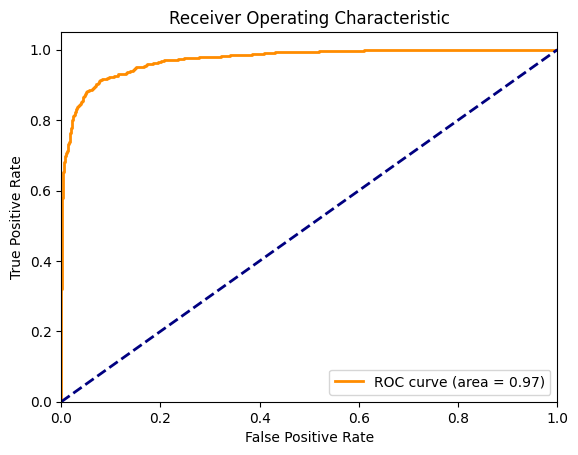

In [116]:
# 11. Visualizar la Curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()